In [1]:
%matplotlib inline
%reload_ext autoreload

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns
import logging

import logging
import sys

def setup_logging(epoch_key, date_format='%d-%b-%y %H:%M:%S', format='%(asctime)s %(message)s'):
    animal, day, epoch = epoch_key
    log_filename = f"{animal}_{day:02d}_{epoch:02d}_test_speed_gpu_shared.log"

    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter(fmt=format, datefmt=date_format)

    stdout_handler = logging.StreamHandler(sys.stdout)
    stdout_handler.setLevel(logging.INFO)
    stdout_handler.setFormatter(formatter)

    file_handler = logging.FileHandler(log_filename)
    file_handler.setLevel(logging.INFO)
    file_handler.setFormatter(formatter)

    logger.addHandler(file_handler)
    logger.addHandler(stdout_handler)

sns.set_context("talk")

In [3]:
epoch_key = 'Jaq', 3, 12

In [4]:
setup_logging(epoch_key)

In [11]:
import cupy as cp

mempool = cp.get_default_memory_pool()
mempool.free_all_blocks()

19-Jan-22 22:59:04 add pending dealloc: module_unload ? bytes
19-Jan-22 22:59:04 add pending dealloc: module_unload ? bytes


In [5]:
from src.load_data import load_data


data = load_data(epoch_key,
                 position_to_linearize=['nose_x', 'nose_y'],
                 max_distance_from_well=5,
                 min_distance_traveled=30)

19-Jan-22 21:20:46 Loading position info...
19-Jan-22 21:21:27 Loading multiunit...
19-Jan-22 21:21:47 Loading spikes...
19-Jan-22 21:21:52 Finding ripple times...


In [6]:
from replay_trajectory_classification import ClusterlessClassifier
from src.parameters import WTRACK_EDGE_ORDER, WTRACK_EDGE_SPACING
from replay_trajectory_classification.environments import Environment
from replay_trajectory_classification.continuous_state_transitions import RandomWalk, Uniform
from replay_trajectory_classification.initial_conditions import \
    UniformInitialConditions
from replay_trajectory_classification.discrete_state_transitions import \
    DiagonalDiscrete
import pprint


clusterless_algorithm = 'multiunit_likelihood_gpu_shared'
clusterless_algorithm_params = {
    'mark_std': 20.0,
    'position_std': 8.0,
}

environment = Environment(
    place_bin_size=2.5,
    track_graph=data["track_graph"],
    edge_order=WTRACK_EDGE_ORDER,
    edge_spacing=WTRACK_EDGE_SPACING
)

continuous_transition_types = [[RandomWalk(),  Uniform()],
                               [Uniform(), Uniform()]]

classifier_parameters = dict(
    environments=environment,
    continuous_transition_types=continuous_transition_types,
    clusterless_algorithm=clusterless_algorithm,
    clusterless_algorithm_params=clusterless_algorithm_params,
    discrete_transition_type=DiagonalDiscrete(0.968),
    initial_conditions_type=UniformInitialConditions(),
)
logging.info(pprint.pprint(classifier_parameters))

{'clusterless_algorithm': 'multiunit_likelihood_gpu_shared',
 'clusterless_algorithm_params': {'mark_std': 20.0, 'position_std': 8.0},
 'continuous_transition_types': [[RandomWalk(environment_name='', movement_var=6.0, movement_mean=0.0),
                                  Uniform(environment_name='', environment2_name=None)],
                                 [Uniform(environment_name='', environment2_name=None),
                                  Uniform(environment_name='', environment2_name=None)]],
 'discrete_transition_type': DiagonalDiscrete(diagonal_value=0.968),
 'environments': Environment(environment_name='', place_bin_size=2.5, track_graph=<networkx.classes.graph.Graph object at 0x7fb78524ad30>, edge_order=[(0, 1), (1, 2), (2, 3), (1, 4), (4, 5)], edge_spacing=[15, 0, 15, 0], is_track_interior=None, position_range=None, infer_track_interior=True),
 'initial_conditions_type': UniformInitialConditions()}
19-Jan-22 21:22:24 None


In [7]:
logging.info('GPU Shared Memory')

state_names = ['Continuous', 'Fragmented']

classifier = ClusterlessClassifier(**classifier_parameters)
classifier.fit(
    position=data["position_info"].linear_position,
    multiunits=data["multiunits"],

)

results = classifier.predict(
    data["multiunits"],
    time=data["position_info"].index / np.timedelta64(1, "s"),
    state_names=state_names,
    use_gpu=True
)
logging.info('Done...')

19-Jan-22 21:22:24 Cupy Integer
19-Jan-22 21:22:25 Fitting initial conditions...
19-Jan-22 21:22:25 Fitting state transition...
19-Jan-22 21:22:25 Fitting multiunits...
19-Jan-22 21:22:25 init
19-Jan-22 21:22:26 add pending dealloc: cuMemFree_v2 636 bytes
19-Jan-22 21:22:26 add pending dealloc: cuMemFree_v2 1794852 bytes
19-Jan-22 21:22:26 add pending dealloc: cuMemFree_v2 4 bytes
19-Jan-22 21:22:26 add pending dealloc: cuMemFree_v2 636 bytes
19-Jan-22 21:22:26 add pending dealloc: cuMemFree_v2 636 bytes
19-Jan-22 21:22:26 add pending dealloc: cuMemFree_v2 158992 bytes
19-Jan-22 21:22:26 add pending dealloc: cuMemFree_v2 4 bytes
19-Jan-22 21:22:26 add pending dealloc: cuMemFree_v2 636 bytes
19-Jan-22 21:22:27 add pending dealloc: cuMemFree_v2 636 bytes
19-Jan-22 21:22:27 add pending dealloc: cuMemFree_v2 353964 bytes
19-Jan-22 21:22:27 add pending dealloc: cuMemFree_v2 4 bytes
19-Jan-22 21:22:27 dealloc: cuMemFree_v2 636 bytes
19-Jan-22 21:22:27 dealloc: cuMemFree_v2 1794852 bytes
19-J

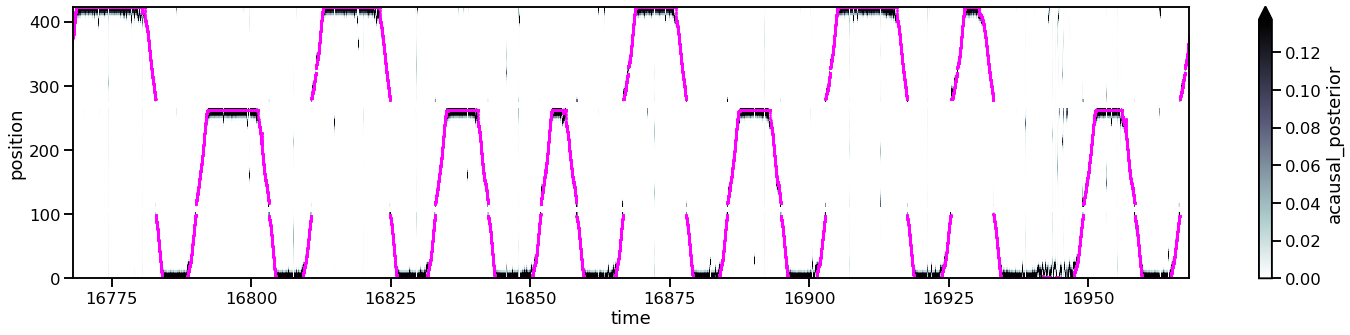

In [10]:
fig, ax = plt.subplots(figsize=(25, 5))
time_slice = slice(200_000, 300_000)

(results
 .acausal_posterior
 .isel(time=time_slice)
 .sum('state')
 .plot(x='time', y='position', robust=True, ax=ax, vmin=0.0, cmap='bone_r'))

ax.scatter(results.isel(time=time_slice).time,
           data['position_info'].iloc[time_slice].linear_position, color='magenta', s=1)